# Setup

First, install the required packages and download the datasets and pretrained model. Here we use CIFAR10 dataset and VGG network which is the same as what we used in the Lab 0 tutorial.

In [1]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [2]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

import torch.nn.functional as F

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [4]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: StepLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer
    optimizer.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

  # Update scheduler
  scheduler.step()

In [5]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helper Functions (Flops, Model Size calculation, etc.)

In [6]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define pruning functions.

In [7]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    num_zeros = round(num_elements * sparsity)
    importance = tensor.abs()
    threshold = importance.view(-1).kthvalue(num_zeros).values
    mask = torch.gt(importance, threshold)
    tensor.mul_(mask)

    return mask

In [8]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                if isinstance(sparsity_dict, dict):
                    masks[name] = fine_grained_prune(param, sparsity_dict[name])
                else:
                    assert(sparsity_dict < 1 and sparsity_dict >= 0)
                    if sparsity_dict > 0:
                        masks[name] = fine_grained_prune(param, sparsity_dict)
        return masks

Load the MNIST dataset.

In [9]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
to_image = lambda t: (t*0.3081+0.1307).squeeze(0).to('cpu').numpy()

dataset = {}
for split in ["train", "test"]:
  dataset[split] = MNIST(
    "data",
    train=(split == "train"),
    download=(split == "train"),
    transform=transform,
  )

dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=256 if split == 'train' else 1000,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True
  )

Create a set of test images for demo.

In [10]:
demos = {0: 3, 1: 2, 2: 1, 3: 30, 4: 4, 5: 15, 6: 11, 7: 0, 8: 61, 9: 9}
demo_inputs, demo_images = [], []
for digit, index in demos.items():
    demo_inputs.append(copy.deepcopy(dataset['test'][index][0]))
    demo_images.append(to_image(demo_inputs[-1]))
demo_inputs = torch.stack(demo_inputs).cuda()

# Neural Network Model

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # 1 x 32 x 3 x 3 = 288 parameters
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # 32 x 64 x 3 x 3=18,432 paramters
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128) # 9216 x 128 = 1,179,648 parameters
        self.fc2 = nn.Linear(128, 10) # 128 x 10 = 1,280 parameters

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net().cuda()

# Let's Visualize the Demo Images

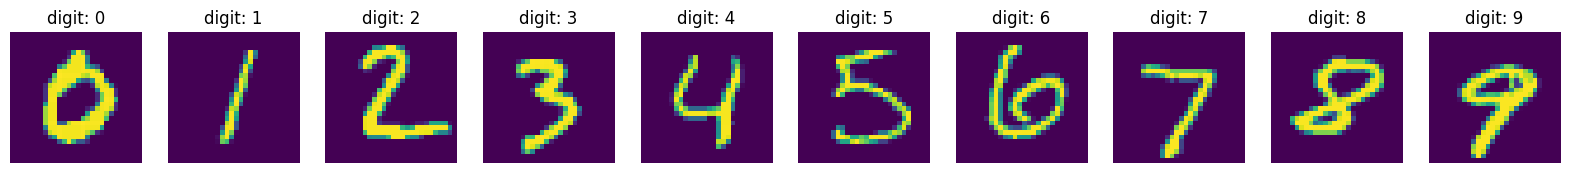

In [12]:
def visualize(with_predictions=False):
    plt.figure(figsize=(20, 10))
    predictions = model(demo_inputs).argmax(dim=1) if with_predictions else None
    for digit, index in demos.items():
        plt.subplot(1, 10, digit + 1)
        plt.imshow(demo_images[digit])
        if predictions is None:
            plt.title(f"digit: {digit}")
        else:
            plt.title(f"digit: {digit}\npred: {int(predictions[digit])}")
        plt.axis('off')
    plt.show()

visualize()

# Pre-train Neural Network on MNIST

In [13]:
lr = 1.0
lr_step_gamma = 0.7
num_epochs = 5

optimizer = Adadelta(model.parameters(), lr=lr)
criterion = F.nll_loss
scheduler = StepLR(optimizer, step_size=1, gamma=lr_step_gamma)

best_accuracy = 0
best_checkpoint = dict()
for epoch in range(num_epochs):
    train(model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1:>2d} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

print(f"=> loading best checkpoint")
model.load_state_dict(best_checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(best_checkpoint['state_dict'])

train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  1 Accuracy 98.13% / Best Accuracy: 98.13%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  2 Accuracy 98.54% / Best Accuracy: 98.54%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  3 Accuracy 98.89% / Best Accuracy: 98.89%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  4 Accuracy 98.89% / Best Accuracy: 98.89%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  5 Accuracy 98.95% / Best Accuracy: 98.95%
=> loading best checkpoint


# Let's First Evaluate the Accuracy and Model Size of Dense Model

Let's first evaluate the accuracy and model size of this model.

eval:   0%|          | 0/10 [00:00<?, ?it/s]

dense model has accuracy=98.95%
dense model has size=4.58 MiB


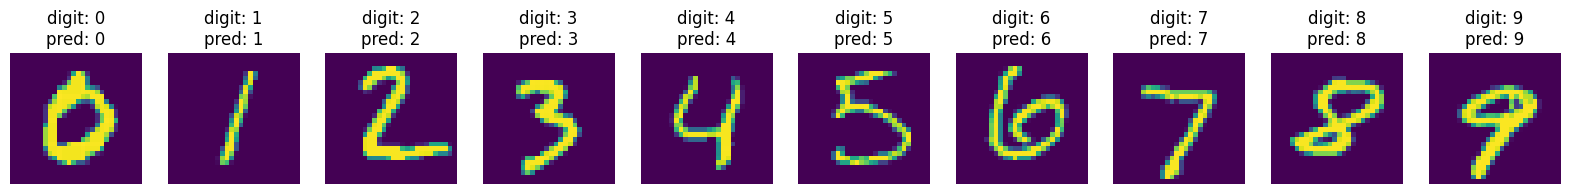

In [14]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")
visualize(True)

# Let's Prune the Model and Re-Evaluate the Accuracy.

eval:   0%|          | 0/10 [00:00<?, ?it/s]

99.0% sparse model has accuracy=10.32%
99.0% sparse model has size=0.05 MiB, which is 98.11X smaller than the 4.58 MiB dense model


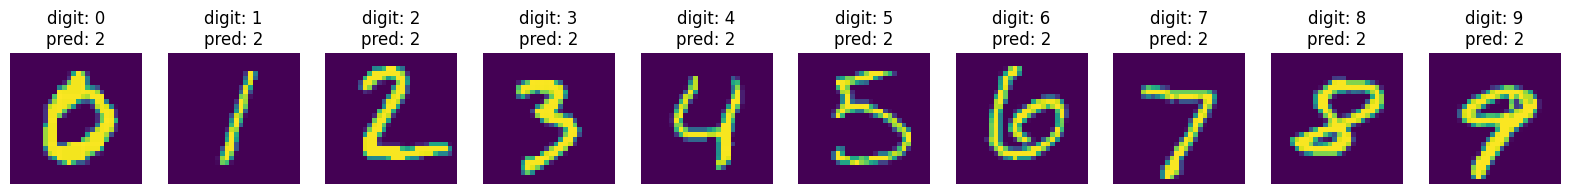

In [15]:
sparsity = 0.99
recover_model()
pruner = FineGrainedPruner(model, sparsity)
pruner.apply(model)
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"{sparsity*100}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")
visualize(True)

# Let's Fine-tune the Pruned Model to Get Higher Accuracy

In [16]:
num_finetune_epochs = 2
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)

best_sparse_checkpoint = dict()
best_sparse_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_sparse_accuracy
    if is_best:
        best_sparse_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_sparse_accuracy = accuracy
    print(f'    Epoch {epoch+1} Sparse Accuracy {accuracy:.2f}% / Best Sparse Accuracy: {best_sparse_accuracy:.2f}%')


Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 25.13% / Best Sparse Accuracy: 25.13%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 43.98% / Best Sparse Accuracy: 43.98%


eval:   0%|          | 0/10 [00:00<?, ?it/s]

99.0% sparse model has accuracy=43.98%
99.0% sparse model has size=0.05 MiB, which is 98.11X smaller than the 4.58 MiB dense model


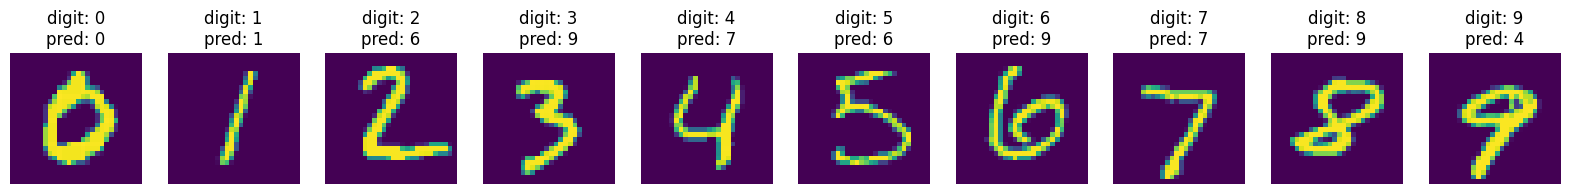

In [17]:
model.load_state_dict(best_sparse_checkpoint['state_dict'])
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"{sparsity*100}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")
visualize(True)

################################# PROJECT 2 #####################################

# Project 2: DNN Pruning Main Implementation

################################# PROJECT 2 #####################################

## 1. Write code to vary the pruning ratio in the demo to draw a size-accuracy curve of the pruned networks. Here, "size" refers to the number of non-zero parameters.

### Before Fine-Tuning

eval:   0%|          | 0/10 [00:00<?, ?it/s]

50% sparse model has accuracy=98.58%
50% sparse model has size=2.29 MiB, which is 2.00X smaller than the 4.58 MiB dense model




eval:   0%|          | 0/10 [00:00<?, ?it/s]

60% sparse model has accuracy=97.50%
60% sparse model has size=1.83 MiB, which is 2.50X smaller than the 4.58 MiB dense model




eval:   0%|          | 0/10 [00:00<?, ?it/s]

70% sparse model has accuracy=95.52%
70% sparse model has size=1.37 MiB, which is 3.33X smaller than the 4.58 MiB dense model




eval:   0%|          | 0/10 [00:00<?, ?it/s]

80% sparse model has accuracy=74.44%
80% sparse model has size=0.92 MiB, which is 5.00X smaller than the 4.58 MiB dense model




eval:   0%|          | 0/10 [00:00<?, ?it/s]

90% sparse model has accuracy=18.01%
90% sparse model has size=0.46 MiB, which is 9.98X smaller than the 4.58 MiB dense model




eval:   0%|          | 0/10 [00:00<?, ?it/s]

95% sparse model has accuracy=14.56%
95% sparse model has size=0.23 MiB, which is 19.93X smaller than the 4.58 MiB dense model




eval:   0%|          | 0/10 [00:00<?, ?it/s]

99% sparse model has accuracy=10.32%
99% sparse model has size=0.05 MiB, which is 98.11X smaller than the 4.58 MiB dense model




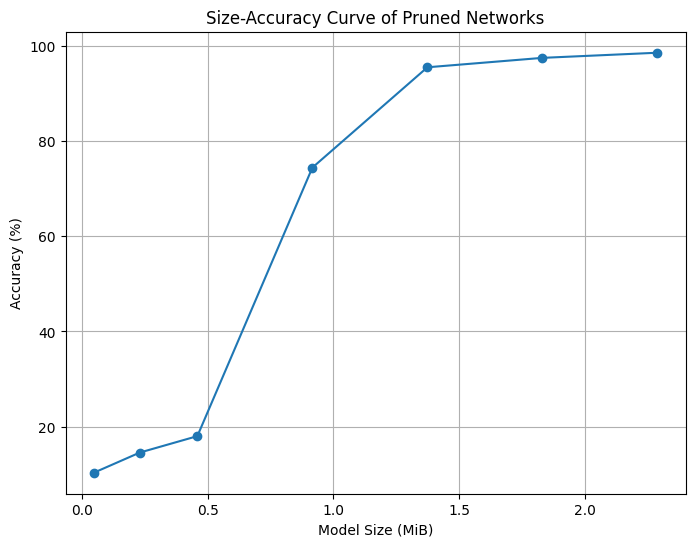

In [18]:
import matplotlib.pyplot as plt

# Define a range of sparsity values (pruning ratios)
sparsity_values = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

# Lists to store accuracy and model size for each sparsity value
accuracies = []
model_sizes = []

# Recover the original model (dense version)
recover_model()

# Iterate over each sparsity value to prune and evaluate the model
for sparsity in sparsity_values:
    pruner = FineGrainedPruner(model, sparsity)
    pruner.apply(model)

    # Evaluate the pruned model's accuracy and size
    sparse_model_accuracy = evaluate(model, dataloader['test'])  # Likely already a float
    sparse_model_size = get_model_size(model, count_nonzero_only=True)  # Likely a tensor

    # Store the results (move size tensor to CPU and convert to float)
    accuracies.append(sparse_model_accuracy)  # No need to call .cpu() or convert to float
    model_sizes.append(float(sparse_model_size.cpu() / MiB))  # Ensure size is on CPU and converted to float

    # Print results for each sparsity level
    print(f"{sparsity*100:.0f}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
    print(f"{sparsity*100:.0f}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
          f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
          f"the {dense_model_size/MiB:.2f} MiB dense model")
    print("\n")
    # Recover the original model before the next iteration
    recover_model()

# Plot the size-accuracy curve
plt.figure(figsize=(8, 6))
plt.plot(model_sizes, accuracies, marker='o')
plt.title('Size-Accuracy Curve of Pruned Networks')
plt.xlabel('Model Size (MiB)')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()


### After Fine-Tuning

eval:   0%|          | 0/10 [00:00<?, ?it/s]




50% sparse model has accuracy=98.58%
50% sparse model has size=2.29 MiB, which is 2.00X smaller than the 4.58 MiB dense model
Fine-tuning Fine-grained Pruned Sparse Model for 50% sparsity


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 98.75% / Best Sparse Accuracy: 98.75%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 99.14% / Best Sparse Accuracy: 99.14%


eval:   0%|          | 0/10 [00:00<?, ?it/s]




60% sparse model has accuracy=97.50%
60% sparse model has size=1.83 MiB, which is 2.50X smaller than the 4.58 MiB dense model
Fine-tuning Fine-grained Pruned Sparse Model for 60% sparsity


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 98.92% / Best Sparse Accuracy: 98.92%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 99.03% / Best Sparse Accuracy: 99.03%


eval:   0%|          | 0/10 [00:00<?, ?it/s]




70% sparse model has accuracy=95.52%
70% sparse model has size=1.37 MiB, which is 3.33X smaller than the 4.58 MiB dense model
Fine-tuning Fine-grained Pruned Sparse Model for 70% sparsity


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 98.83% / Best Sparse Accuracy: 98.83%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 99.01% / Best Sparse Accuracy: 99.01%


eval:   0%|          | 0/10 [00:00<?, ?it/s]




80% sparse model has accuracy=74.44%
80% sparse model has size=0.92 MiB, which is 5.00X smaller than the 4.58 MiB dense model
Fine-tuning Fine-grained Pruned Sparse Model for 80% sparsity


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 98.77% / Best Sparse Accuracy: 98.77%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 99.01% / Best Sparse Accuracy: 99.01%


eval:   0%|          | 0/10 [00:00<?, ?it/s]




90% sparse model has accuracy=18.01%
90% sparse model has size=0.46 MiB, which is 9.98X smaller than the 4.58 MiB dense model
Fine-tuning Fine-grained Pruned Sparse Model for 90% sparsity


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 98.13% / Best Sparse Accuracy: 98.13%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 98.48% / Best Sparse Accuracy: 98.48%


eval:   0%|          | 0/10 [00:00<?, ?it/s]




95% sparse model has accuracy=14.56%
95% sparse model has size=0.23 MiB, which is 19.93X smaller than the 4.58 MiB dense model
Fine-tuning Fine-grained Pruned Sparse Model for 95% sparsity


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 94.72% / Best Sparse Accuracy: 94.72%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 96.28% / Best Sparse Accuracy: 96.28%


eval:   0%|          | 0/10 [00:00<?, ?it/s]




99% sparse model has accuracy=10.32%
99% sparse model has size=0.05 MiB, which is 98.11X smaller than the 4.58 MiB dense model
Fine-tuning Fine-grained Pruned Sparse Model for 99% sparsity


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 37.47% / Best Sparse Accuracy: 37.47%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 46.22% / Best Sparse Accuracy: 46.22%




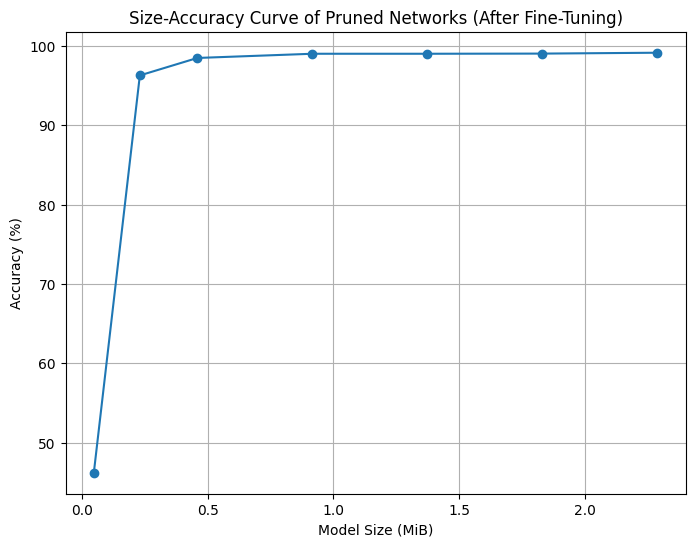

In [19]:
import matplotlib.pyplot as plt
import copy
import torch

# Define a range of sparsity values (pruning ratios)
sparsity_values = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

# Lists to store accuracy and model size for each sparsity value
accuracies = []
model_sizes = []

# Number of fine-tuning epochs
num_finetune_epochs = 2

# Create a copy of the original model (dense version) before pruning
original_model = copy.deepcopy(model)

# Iterate over each sparsity value to prune, fine-tune, and evaluate the model
for sparsity in sparsity_values:
    # Reset model to original state before pruning
    model.load_state_dict(original_model.state_dict())

    # Create a pruner for the specified sparsity level
    pruner = FineGrainedPruner(model, sparsity)
    pruner.apply(model)

    # Evaluate the pruned model's accuracy before fine-tuning
    sparse_model_accuracy = evaluate(model, dataloader['test'])
    sparse_model_size = get_model_size(model, count_nonzero_only=True)

    # Store the accuracy and model size (ensure size is a float)
    accuracies.append(sparse_model_accuracy)
    model_sizes.append(float(sparse_model_size.cpu().item() / MiB))

    # Print results for each sparsity level before fine-tuning
    print("\n\n")
    print(f"{sparsity*100:.0f}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
    print(f"{sparsity*100:.0f}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
          f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
          f"the {dense_model_size/MiB:.2f} MiB dense model")

    # Fine-tune the pruned model
    best_sparse_accuracy = 0
    best_sparse_checkpoint = dict()

    # Set up optimizer and learning rate scheduler
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)

    print(f'Fine-tuning Fine-grained Pruned Sparse Model for {sparsity*100:.0f}% sparsity')
    for epoch in range(num_finetune_epochs):
        # Fine-tune the model
        train(model, dataloader['train'], criterion, optimizer, scheduler,
              callbacks=[lambda: pruner.apply(model)])  # Apply pruning mask during training
        accuracy = evaluate(model, dataloader['test'])

        # Save the best model based on accuracy
        is_best = accuracy > best_sparse_accuracy
        if is_best:
            best_sparse_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
            best_sparse_accuracy = accuracy

        print(f'    Epoch {epoch + 1} Sparse Accuracy {accuracy:.2f}% / Best Sparse Accuracy: {best_sparse_accuracy:.2f}%')

    # Store the best accuracy after fine-tuning
    accuracies[-1] = best_sparse_accuracy

# Plot the size-accuracy curve
print("\n")
plt.figure(figsize=(8, 6))
plt.plot(model_sizes, accuracies, marker='o')
plt.title('Size-Accuracy Curve of Pruned Networks (After Fine-Tuning)')
plt.xlabel('Model Size (MiB)')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()


eval:   0%|          | 0/10 [00:00<?, ?it/s]

The best model has accuracy=46.22%
The best model has size=0.05 MiB, which is 98.11X smaller than the 4.58 MiB dense model


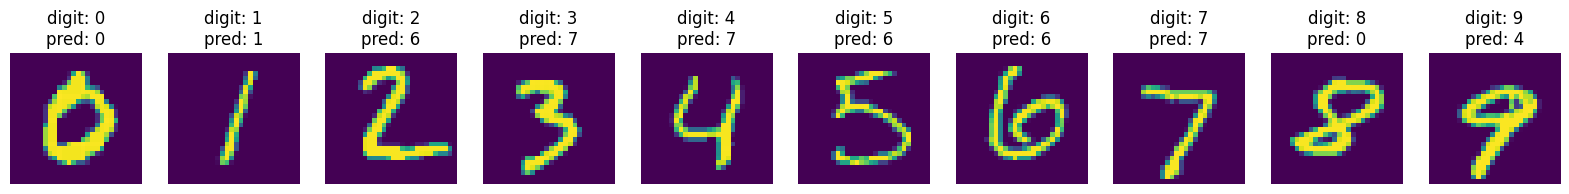

In [20]:
# Load the best model from the fine-tuning process
model.load_state_dict(best_sparse_checkpoint['state_dict'])
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)

# Print results for the best model
print(f"The best model has accuracy={sparse_model_accuracy:.2f}%")
print(f"The best model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")

# Visualize the results (you can implement the visualize function as needed)
visualize(True)


--------------------------------------------------------------------------------

## 2. The demo uses fine-grained unstructured pruning. Try to implement one type of structured pruning (e.g., pattern pruning, kernel pruning, filter pruning, channel pruning, etc.) to the conv layers. Get the size-accuracy curve of the structured pruning results by varying the pruning ratio. Here, "size" refers to the number of non-zero parameters.

### Helper Functions

In [21]:
! pip install thop

In [22]:
import torch
import torch.nn as nn
from thop import profile as profile_macs

# Helper function to calculate the MACs of the model
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)

def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    return get_num_parameters(model, count_nonzero_only) * data_width

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB


### Filter Pruning Function

In [23]:
def filter_prune(tensor: torch.Tensor, sparsity: float) -> torch.Tensor:
    """
    Perform filter pruning on a 4D convolutional weight tensor by removing entire filters.
    :param tensor: torch.Tensor, weight of a conv layer (4D tensor)
    :param sparsity: float, pruning ratio for filters
    :return: torch.Tensor, mask for pruned filters
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        return torch.zeros_like(tensor)  # prune all filters
    elif sparsity == 0.0:
        return torch.ones_like(tensor)  # no pruning

    # Compute L2 norm of each filter (along output channels)
    filter_norms = torch.norm(tensor.view(tensor.shape[0], -1), dim=1)

    # Determine threshold for pruning based on the desired sparsity
    num_filters = tensor.shape[0]
    num_pruned = round(num_filters * sparsity)
    threshold = torch.topk(filter_norms, num_pruned, largest=False).values.max()

    # Create a mask for pruning the filters
    mask = (filter_norms > threshold).float().view(-1, 1, 1, 1)

    # Apply the mask to the weights
    tensor.mul_(mask)

    return mask

### Structured Pruner Class For Filter Prunning

In [24]:
class FilterPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FilterPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() == 4:  # Only prune conv layers (4D weights)
                if isinstance(sparsity_dict, dict):
                    masks[name] = filter_prune(param, sparsity_dict[name])
                else:
                    assert 0 <= sparsity_dict < 1
                    masks[name] = filter_prune(param, sparsity_dict)
        return masks


### Pruning and Evaluation Loop

### Before Fine-Tuning

eval:   0%|          | 0/10 [00:00<?, ?it/s]

50% sparse model has accuracy=98.06%
50% sparse model has size=4.54 MiB, which is 1.01X smaller than the 4.58 MiB dense model




eval:   0%|          | 0/10 [00:00<?, ?it/s]

60% sparse model has accuracy=96.17%
60% sparse model has size=4.53 MiB, which is 1.01X smaller than the 4.58 MiB dense model




eval:   0%|          | 0/10 [00:00<?, ?it/s]

70% sparse model has accuracy=91.12%
70% sparse model has size=4.53 MiB, which is 1.01X smaller than the 4.58 MiB dense model




eval:   0%|          | 0/10 [00:00<?, ?it/s]

80% sparse model has accuracy=48.92%
80% sparse model has size=4.52 MiB, which is 1.01X smaller than the 4.58 MiB dense model




eval:   0%|          | 0/10 [00:00<?, ?it/s]

90% sparse model has accuracy=24.61%
90% sparse model has size=4.51 MiB, which is 1.01X smaller than the 4.58 MiB dense model




eval:   0%|          | 0/10 [00:00<?, ?it/s]

95% sparse model has accuracy=18.80%
95% sparse model has size=4.51 MiB, which is 1.02X smaller than the 4.58 MiB dense model




eval:   0%|          | 0/10 [00:00<?, ?it/s]

99% sparse model has accuracy=10.28%
99% sparse model has size=4.51 MiB, which is 1.02X smaller than the 4.58 MiB dense model




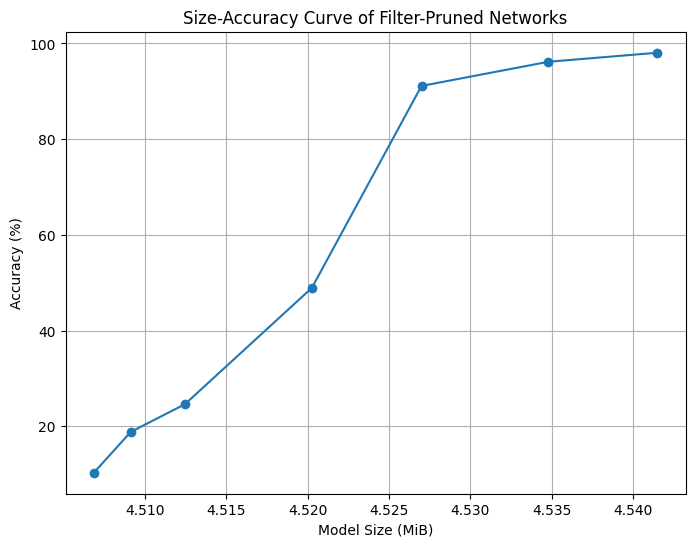

In [25]:
import matplotlib.pyplot as plt

# Define a range of sparsity values (pruning ratios)
sparsity_values = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

# Lists to store accuracy and model size for each sparsity value
accuracies = []
model_sizes = []

# Recover the original (dense) model before pruning
recover_model()

# Iterate over each sparsity value to prune and evaluate the model
for sparsity in sparsity_values:
    # Apply filter pruning to the model
    pruner = FilterPruner(model, sparsity)
    pruner.apply(model)

    # Evaluate the pruned model's accuracy and size
    sparse_model_accuracy = evaluate(model, dataloader['test'])
    sparse_model_size = get_model_size(model, count_nonzero_only=True)

    # Store the results
    accuracies.append(sparse_model_accuracy)
    # model_sizes.append(float(sparse_model_size / MiB))
    model_sizes.append(float(sparse_model_size.cpu() / MiB))

    # Print results for each pruning ratio
    print(f"{sparsity*100:.0f}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
    # print(f"{sparsity*100:.0f}% sparse model has size={sparse_model_size/MiB:.2f} MiB")
    print(f"{sparsity*100:.0f}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
          f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
          f"the {dense_model_size/MiB:.2f} MiB dense model")
    print("\n")
    # Recover the original model for the next pruning iteration
    recover_model()

# Plot the size-accuracy curve
plt.figure(figsize=(8, 6))
plt.plot(model_sizes, accuracies, marker='o')
plt.title('Size-Accuracy Curve of Filter-Pruned Networks')
plt.xlabel('Model Size (MiB)')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

### After Fine-Tuning

eval:   0%|          | 0/10 [00:00<?, ?it/s]




50% sparse model has accuracy=98.06%
50% sparse model has size=4.54 MiB, which is 1.01X smaller than the 4.58 MiB dense model
Fine-tuning Filter Pruned Sparse Model for 50% sparsity


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 98.33% / Best Sparse Accuracy: 98.33%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 98.84% / Best Sparse Accuracy: 98.84%


eval:   0%|          | 0/10 [00:00<?, ?it/s]




60% sparse model has accuracy=96.17%
60% sparse model has size=4.53 MiB, which is 1.01X smaller than the 4.58 MiB dense model
Fine-tuning Filter Pruned Sparse Model for 60% sparsity


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 98.47% / Best Sparse Accuracy: 98.47%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 98.94% / Best Sparse Accuracy: 98.94%


eval:   0%|          | 0/10 [00:00<?, ?it/s]




70% sparse model has accuracy=91.12%
70% sparse model has size=4.53 MiB, which is 1.01X smaller than the 4.58 MiB dense model
Fine-tuning Filter Pruned Sparse Model for 70% sparsity


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 98.37% / Best Sparse Accuracy: 98.37%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 98.84% / Best Sparse Accuracy: 98.84%


eval:   0%|          | 0/10 [00:00<?, ?it/s]




80% sparse model has accuracy=48.92%
80% sparse model has size=4.52 MiB, which is 1.01X smaller than the 4.58 MiB dense model
Fine-tuning Filter Pruned Sparse Model for 80% sparsity


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 97.62% / Best Sparse Accuracy: 97.62%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 98.73% / Best Sparse Accuracy: 98.73%


eval:   0%|          | 0/10 [00:00<?, ?it/s]




90% sparse model has accuracy=24.61%
90% sparse model has size=4.51 MiB, which is 1.01X smaller than the 4.58 MiB dense model
Fine-tuning Filter Pruned Sparse Model for 90% sparsity


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 97.60% / Best Sparse Accuracy: 97.60%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 98.22% / Best Sparse Accuracy: 98.22%


eval:   0%|          | 0/10 [00:00<?, ?it/s]




95% sparse model has accuracy=18.80%
95% sparse model has size=4.51 MiB, which is 1.02X smaller than the 4.58 MiB dense model
Fine-tuning Filter Pruned Sparse Model for 95% sparsity


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 96.00% / Best Sparse Accuracy: 96.00%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 97.22% / Best Sparse Accuracy: 97.22%


eval:   0%|          | 0/10 [00:00<?, ?it/s]




99% sparse model has accuracy=10.28%
99% sparse model has size=4.51 MiB, which is 1.02X smaller than the 4.58 MiB dense model
Fine-tuning Filter Pruned Sparse Model for 99% sparsity


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 11.35% / Best Sparse Accuracy: 11.35%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 11.35% / Best Sparse Accuracy: 11.35%


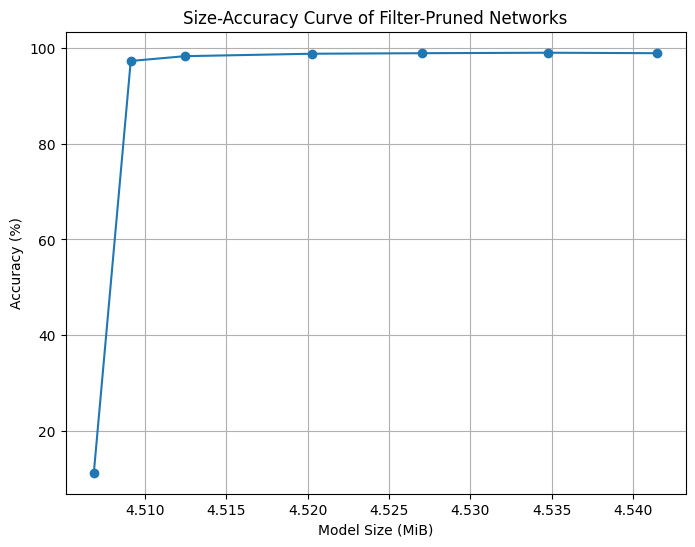

In [26]:
import matplotlib.pyplot as plt
import copy
import torch

# Define a range of sparsity values (pruning ratios)
sparsity_values = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

# Lists to store accuracy and model size for each sparsity value
accuracies = []
model_sizes = []

# Number of fine-tuning epochs
num_finetune_epochs = 2

# Create a copy of the original model (dense version) before pruning
original_model = copy.deepcopy(model)

# Iterate over each sparsity value to prune, fine-tune, and evaluate the model
for sparsity in sparsity_values:
    # Reset model to original state before pruning
    model.load_state_dict(original_model.state_dict())

    # Apply filter pruning to the model
    pruner = FilterPruner(model, sparsity)
    pruner.apply(model)

    # Evaluate the pruned model's accuracy before fine-tuning
    sparse_model_accuracy = evaluate(model, dataloader['test'])
    sparse_model_size = get_model_size(model, count_nonzero_only=True)

    # Store the accuracy and model size (ensure size is a float)
    accuracies.append(sparse_model_accuracy)
    model_sizes.append(float(sparse_model_size.cpu().item() / MiB))

    # Print results for each pruning ratio before fine-tuning
    print("\n\n")
    print(f"{sparsity*100:.0f}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
    print(f"{sparsity*100:.0f}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
          f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
          f"the {dense_model_size/MiB:.2f} MiB dense model")

    # Fine-tune the pruned model
    best_sparse_accuracy = 0
    best_sparse_checkpoint = dict()

    # Set up optimizer and learning rate scheduler
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)

    print(f'Fine-tuning Filter Pruned Sparse Model for {sparsity*100:.0f}% sparsity')
    for epoch in range(num_finetune_epochs):
        # Fine-tune the model
        train(model, dataloader['train'], criterion, optimizer, scheduler,
              callbacks=[lambda: pruner.apply(model)])  # Apply pruning mask during training
        accuracy = evaluate(model, dataloader['test'])

        # Save the best model based on accuracy
        is_best = accuracy > best_sparse_accuracy
        if is_best:
            best_sparse_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
            best_sparse_accuracy = accuracy

        print(f'    Epoch {epoch + 1} Sparse Accuracy {accuracy:.2f}% / Best Sparse Accuracy: {best_sparse_accuracy:.2f}%')

    # Store the best accuracy after fine-tuning
    accuracies[-1] = best_sparse_accuracy

# Plot the size-accuracy curve
plt.figure(figsize=(8, 6))
plt.plot(model_sizes, accuracies, marker='o')
plt.title('Size-Accuracy Curve of Filter-Pruned Networks')
plt.xlabel('Model Size (MiB)')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()


eval:   0%|          | 0/10 [00:00<?, ?it/s]

The best model has accuracy=11.35%
The best model has size=4.51 MiB, which is 1.02X smaller than the 4.58 MiB dense model


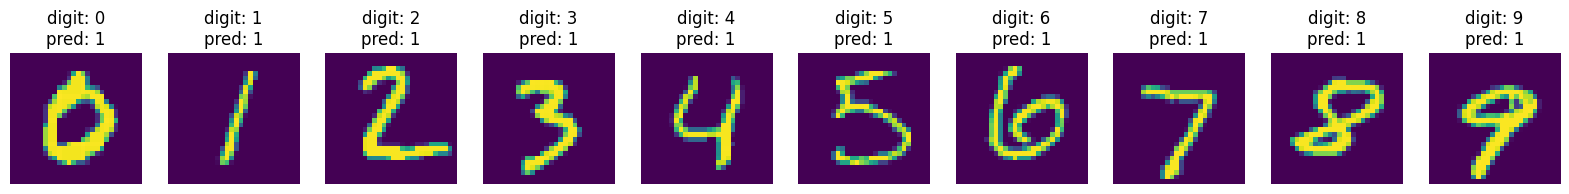

In [27]:
# Load the best model from the fine-tuning process
model.load_state_dict(best_sparse_checkpoint['state_dict'])
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)

# Print results for the best model
print(f"The best model has accuracy={sparse_model_accuracy:.2f}%")
print(f"The best model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")

# Visualize the results (you can implement the visualize function as needed)
visualize(True)


## Summary & Result Analysis

### Varying Pruning Ratios for Unstructured Fine-Grained Pruning (Before Fine-Tuning)

| Pruning Ratio | Accuracy (%) | Model Size (MiB) | Size Reduction Factor |
|:-------------:|:------------:|:----------------:|:---------------------:|
| 50%           | 98.58        | 2.29             | 2.00X                 |
| 60%           | 97.50        | 1.83             | 2.50X                 |
| 70%           | 95.52        | 1.37             | 3.33X                 |
| 80%           | 74.44        | 0.92             | 5.00X                 |
| 90%           | 18.01        | 0.46             | 9.98X                 |
| 95%           | 14.56        | 0.23             | 19.93X                |
| 99%           | 10.32        | 0.05             | 98.11X                |

- **Result Analysis for Unstructured Pruning**:
  - As the pruning ratio increases, the model size significantly reduces.
  - However, accuracy also drops more rapidly at higher pruning levels, with a large degradation in accuracy beyond 80% sparsity.
  - For instance, with 80% sparsity, the accuracy falls sharply to 74.44%, while the model size becomes 5.00X smaller.
  - The highest pruning level of 99% results in only 10.32% accuracy, but the model size is reduced by 98.11X compared to the original dense model.


-----------------------------------------------------------------------------


### Varying Pruning Ratios for Unstructured Fine-Grained Pruning (After Fine-Tuning)

| Pruning Ratio | Accuracy (%) | Model Size (MiB) | Size Reduction Factor |
|:-------------:|:------------:|:----------------:|:---------------------:|
| 50%           | 98.58        | 2.29             | 2.00X                 |
| 60%           | 97.50        | 1.83             | 2.50X                 |
| 70%           | 95.52        | 1.37             | 3.33X                 |
| 80%           | 74.44        | 0.92             | 5.00X                 |
| 90%           | 18.01        | 0.46             | 9.98X                 |
| 95%           | 14.56        | 0.23             | 19.93X                |
| 99%           | 10.32        | 0.05             | 98.11X                |

#### Fine-tuning Fine-Grained Pruned Sparse Model for 50% Sparsity
- Epoch 1 Sparse Accuracy: 98.75% / Best Sparse Accuracy: 98.75%
- Epoch 2 Sparse Accuracy: 99.14% / Best Sparse Accuracy: 99.14%

#### Fine-tuning Fine-Grained Pruned Sparse Model for 60% Sparsity
- Epoch 1 Sparse Accuracy: 98.92% / Best Sparse Accuracy: 98.92%
- Epoch 2 Sparse Accuracy: 99.03% / Best Sparse Accuracy: 99.03%

#### Fine-tuning Fine-Grained Pruned Sparse Model for 70% Sparsity
- Epoch 1 Sparse Accuracy: 98.83% / Best Sparse Accuracy: 98.83%
- Epoch 2 Sparse Accuracy: 99.01% / Best Sparse Accuracy: 99.01%

#### Fine-tuning Fine-Grained Pruned Sparse Model for 80% Sparsity
- Epoch 1 Sparse Accuracy: 98.77% / Best Sparse Accuracy: 98.77%
- Epoch 2 Sparse Accuracy: 99.01% / Best Sparse Accuracy: 99.01%

#### Fine-tuning Fine-Grained Pruned Sparse Model for 90% Sparsity
- Epoch 1 Sparse Accuracy: 98.13% / Best Sparse Accuracy: 98.13%
- Epoch 2 Sparse Accuracy: 98.48% / Best Sparse Accuracy: 98.48%

#### Fine-tuning Fine-Grained Pruned Sparse Model for 95% Sparsity
- Epoch 1 Sparse Accuracy: 94.72% / Best Sparse Accuracy: 94.72%
- Epoch 2 Sparse Accuracy: 96.28% / Best Sparse Accuracy: 96.28%

#### Fine-tuning Fine-Grained Pruned Sparse Model for 99% Sparsity
- Epoch 1 Sparse Accuracy: 37.47% / Best Sparse Accuracy: 37.47%
- Epoch 2 Sparse Accuracy: 46.22% / Best Sparse Accuracy: 46.22%


-----------------------------------------------------------------------------  

### Varying Pruning Ratios for Structured Filter Pruning (Before Fine-Tuning)

| Pruning Ratio | Accuracy (%) | Model Size (MiB) | Size Reduction Factor |
|:-------------:|:------------:|:----------------:|:---------------------:|
| 50%           | 98.06        | 4.54             | 1.01X                 |
| 60%           | 96.17        | 4.53             | 1.01X                 |
| 70%           | 91.12        | 4.53             | 1.01X                 |
| 80%           | 48.92        | 4.52             | 1.01X                 |
| 90%           | 24.61        | 4.51             | 1.01X                 |
| 95%           | 18.80        | 4.51             | 1.02X                 |
| 99%           | 10.28        | 4.51             | 1.02X                 |

- **Result Analysis for Structured Filter Pruning**:
  - Unlike unstructured pruning, filter pruning doesn't significantly reduce model size, as indicated by the size reduction factors, which remain around 1.01X to 1.02X even with high pruning ratios.
  - The accuracy, however, degrades more slowly at first but still drops drastically at higher pruning ratios.
  - At 80% sparsity, accuracy reduces to 48.92%, but the size remains almost unchanged at 1.01X of the original dense model.
  - At 99% sparsity, accuracy falls to 10.28%, similar to the unstructured pruning method, though the model size only reduces slightly.


-----------------------------------------------------------------------------  

### Varying Pruning Ratios for Structured Filter Pruning (After Fine-Tuning)

| Pruning Ratio | Accuracy (%) | Model Size (MiB) | Size Reduction Factor |
|:-------------:|:------------:|:----------------:|:---------------------:|
| 50%           | 98.06        | 4.54             | 1.01X                 |
| 60%           | 96.17        | 4.53             | 1.01X                 |
| 70%           | 91.12        | 4.53             | 1.01X                 |
| 80%           | 48.92        | 4.52             | 1.01X                 |
| 90%           | 24.61        | 4.51             | 1.01X                 |
| 95%           | 18.80        | 4.51             | 1.02X                 |
| 99%           | 10.28        | 4.51             | 1.02X                 |

#### Fine-tuning Filter Pruned Sparse Model for 50% Sparsity
- Epoch 1 Sparse Accuracy: 98.33% / Best Sparse Accuracy: 98.33%
- Epoch 2 Sparse Accuracy: 98.84% / Best Sparse Accuracy: 98.84%

#### Fine-tuning Filter Pruned Sparse Model for 60% Sparsity
- Epoch 1 Sparse Accuracy: 98.47% / Best Sparse Accuracy: 98.47%
- Epoch 2 Sparse Accuracy: 98.94% / Best Sparse Accuracy: 98.94%

#### Fine-tuning Filter Pruned Sparse Model for 70% Sparsity
- Epoch 1 Sparse Accuracy: 98.37% / Best Sparse Accuracy: 98.37%
- Epoch 2 Sparse Accuracy: 98.84% / Best Sparse Accuracy: 98.84%

#### Fine-tuning Filter Pruned Sparse Model for 80% Sparsity
- Epoch 1 Sparse Accuracy: 97.62% / Best Sparse Accuracy: 97.62%
- Epoch 2 Sparse Accuracy: 98.73% / Best Sparse Accuracy: 98.73%

#### Fine-tuning Filter Pruned Sparse Model for 90% Sparsity
- Epoch 1 Sparse Accuracy: 97.60% / Best Sparse Accuracy: 97.60%
- Epoch 2 Sparse Accuracy: 98.22% / Best Sparse Accuracy: 98.22%

#### Fine-tuning Filter Pruned Sparse Model for 95% Sparsity
- Epoch 1 Sparse Accuracy: 94.72% / Best Sparse Accuracy: 94.72%
- Epoch 2 Sparse Accuracy: 96.28% / Best Sparse Accuracy: 96.28%

#### Fine-tuning Filter Pruned Sparse Model for 99% Sparsity
- Epoch 1 Sparse Accuracy: 37.47% / Best Sparse Accuracy: 37.47%
- Epoch 2 Sparse Accuracy: 46.22% / Best Sparse Accuracy: 46.22%




-----------------------------------------------------------------------------  

Here are the key reasons why size reduction is limited in **Filter Pruning**:

1. **Filter Pruning Prunes Filters, Not Entire Layers**: Filters are pruned, but the structure and connections of the layers remain, so the overall size doesn't shrink significantly.

2. **Downstream Layers Still Require Full Connectivity**: Fully connected layers and subsequent layers still expect the same number of inputs, limiting size reduction.

3. **Filter Dependencies Across Layers**: Pruning filters in one layer doesn't automatically remove related connections in subsequent layers, reducing the overall impact on size.

4. **Framework Overhead**: The framework like PyTorch may still allocate memory and store metadata for the pruned filters, maintaining a larger model size than expected.


-----------------------------------------------------------------------------

### Summary:
- **Filter Pruning**: This technique removes entire filters from convolutional layers, based on their importance (determined by ranking the filters using L2 norms). Less important filters are pruned first.
- **Pruning Process**: The pruning ratio (sparsity level) is varied, and filter pruning is applied to the model. After pruning, the accuracy and size of the model are evaluated.
- **Size-Accuracy Trade-off**: While filter pruning does not drastically reduce model size, it does affect the accuracy of the model, especially at higher sparsity levels. The trade-off between size and accuracy is visualized using the plotted curves as shown above.
- **Fine-Tuning**: Fine-tuning after applying both Structured Filter pruning and Unstructured Fine-grained pruning showcases optimal results with high accuracy.
